In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Prep

loading csv files from google drive

In [ ]:
directory = '/content/drive/My Drive/NBA Season Data/2018-19'
files = {}
for filename in os.listdir(directory):
  stat,_ = filename.split('.')
  files[stat] = pd.read_csv(os.path.join(directory, filename))
  files[stat].columns = files[stat].columns.str.strip()

In [ ]:
files.keys()

dict_keys(['screen_assists', 'hand_off', 'putback', 'assists', 'pnr_handler', 'post_up', 'box_scores', 'cut', 'catch_and_shoot', 'pnr_man', 'touches', 'shot_chart', 'height_weight', 'isolation', 'drives', 'off_screen', 'spot_up'])

In [ ]:
for name in files.keys():
  print(f"STAT: {name}")
  files[name].info()
  print()

STAT: screen_assists
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530 entries, 0 to 529
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PLAYER          530 non-null    object 
 1   TEAM            530 non-null    object 
 2   SCREEN ASSISTS  530 non-null    float64
dtypes: float64(1), object(2)
memory usage: 12.5+ KB

STAT: hand_off
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PLAYER        280 non-null    object 
 1   TEAM          280 non-null    object 
 2   HANDOFF FREQ  280 non-null    float64
dtypes: float64(1), object(2)
memory usage: 6.7+ KB

STAT: putback
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   

merging dataframes

In [ ]:
players = pd.DataFrame()
for stat in files.keys():
  if players.empty:
    players = files[stat]
  else:
    players = pd.merge(players, files[stat], how="left", on = ["PLAYER", "TEAM"])

players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530 entries, 0 to 529
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PLAYER               530 non-null    object 
 1   TEAM                 530 non-null    object 
 2   SCREEN ASSISTS       530 non-null    float64
 3   HANDOFF FREQ         241 non-null    float64
 4   PUTBACK FREQ         277 non-null    float64
 5   PASSES MADE          530 non-null    float64
 6   PNR HANDLER FREQ     265 non-null    float64
 7   POST UPS             530 non-null    float64
 8   MIN                  530 non-null    float64
 9   FGA                  530 non-null    float64
 10  3PA                  530 non-null    float64
 11  AST                  530 non-null    float64
 12  CUT FREQ             316 non-null    float64
 13  CATCH AND SHOOT FGA  530 non-null    float64
 14  CATCH AND SHOOT 3PA  530 non-null    object 
 15  PNR MAN FREQ         179 non-null    flo

In [ ]:
directory = '/content/drive/My Drive/NBA Season Data/2018-19'
files = {}
for filename in os.listdir(directory):
  stat,_ = filename.split('.')
  files[stat] = pd.read_csv(os.path.join(directory, filename))
  files[stat].columns = files[stat].columns.str.strip()

players18_19 = pd.DataFrame()
for stat in files.keys():
  if players18_19.empty:
    players18_19 = files[stat]
  else:
    players18_19 = pd.merge(players18_19, files[stat], how="left", on = ["PLAYER", "TEAM"])

players18_19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530 entries, 0 to 529
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PLAYER               530 non-null    object 
 1   TEAM                 530 non-null    object 
 2   SCREEN ASSISTS       530 non-null    float64
 3   HANDOFF FREQ         241 non-null    float64
 4   PUTBACK FREQ         277 non-null    float64
 5   PASSES MADE          530 non-null    float64
 6   PNR HANDLER FREQ     265 non-null    float64
 7   POST UPS             530 non-null    float64
 8   MIN                  530 non-null    float64
 9   FGA                  530 non-null    float64
 10  3PA                  530 non-null    float64
 11  AST                  530 non-null    float64
 12  CUT FREQ             316 non-null    float64
 13  CATCH AND SHOOT FGA  530 non-null    float64
 14  CATCH AND SHOOT 3PA  530 non-null    object 
 15  PNR MAN FREQ         179 non-null    flo

In [ ]:
from sklearn.base import TransformerMixin, ClusterMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score

class CleanDataset(TransformerMixin):

  def fit(self, X, y=None):
    return self

  def height_to_inches(self, height):
    ft, inches = height.split('-')
    return int(ft) * 12 + int(inches)

  def transform(self, X, y=None):
    # fill NULL stats
    X.fillna(0, inplace=True)

    # filter out players with less than 15 minutes
    X = X.loc[X['MIN'] >= 15,]

    # convert height
    X['HEIGHT'] = X['HEIGHT'].apply(self.height_to_inches)

    #convert all columns to numeric
    numeric_columns = X.columns.difference(['PLAYER', 'TEAM'])
    X[numeric_columns] = X[numeric_columns].apply(pd.to_numeric, errors='coerce')
    X.fillna(0, inplace=True)

    return X

class NormalizeDataset(TransformerMixin):
  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):

    # Normalize 'SCREEN ASSISTS'
    X.loc[X['AST'] != 0, 'SCREEN ASSISTS'] = X.loc[X['AST'] != 0, 'SCREEN ASSISTS'] / X['AST']

    # Normalize 'PASS OFF DRIVE' when 'DRIVES' is not 0
    X.loc[X['DRIVES'] != 0, 'PASS OFF DRIVE'] = X.loc[X['DRIVES'] != 0, 'PASS OFF DRIVE'] / X.loc[X['DRIVES'] != 0, 'DRIVES']

    # Normalize columns in cols_norm_touches
    cols_norm_touches = ['AST', 'PASSES MADE', 'DRIVES', 'FRONT CT TOUCHES', 'ELBOW TOUCHES', 'PAINT TOUCHES']
    for stat in cols_norm_touches:
        X.loc[:, stat] = (X[stat] / X['TOUCHES']) * 100

    # Rename columns related to touches
    X.rename(columns={'AST': 'AST PER TOUCHES', 'PASSES MADE': 'PASSES PER TOUCHES', 'DRIVES': 'DRIVES PER TOUCHES', 'FRONT CT TOUCHES': 'FRONT CT TOUCH FREQ', 'PAINT TOUCHES':'PAINT TOUCHES FREQ', 'ELBOW TOUCHES':'ELBOW TOUCH FREQ'}, inplace=True)

    # Normalize 'CATCH AND SHOOT 3 FREQ' and 'CORNER 3 FREQ'
    cols_norm_3pa = ['CATCH AND SHOOT 3PA', 'CORNER 3 FGA']
    X['CATCH AND SHOOT 3 FREQ'] = 100 * X['CATCH AND SHOOT 3PA'] / np.where(X['3PA'] != 0, X['3PA'], 1)
    X['CORNER 3 FREQ'] = 100 * X['CORNER 3 FGA'] / np.where(X['3PA'] != 0, X['3PA'], 1)

    # Normalize columns in cols_norm_fga
    cols_norm_fga = ['CATCH AND SHOOT FGA', 'IN THE PAINT FGA', 'MID RANGE FGA', 'CATCH AND SHOOT 3PA', 'CORNER 3 FGA', 'POST UPS']
    for stat in cols_norm_fga:
        X.loc[:, stat] = 100 * X[stat] / X['FGA']

    # Rename columns related to FGA
    X.rename(columns={'CATCH AND SHOOT FGA': 'CATCH AND SHOOT FREQ', 'IN THE PAINT FGA': 'IN THE PAINT FREQ', 'MID RANGE FGA': 'MID RANGE FREQ', 'CATCH AND SHOOT 3PA': 'CATCH AND SHOOT 3 TFREQ', 'CORNER 3 FGA': 'CORNER 3 TFREQ', 'POST UPS': 'POST UPS FREQ'}, inplace=True)

    # Drop unnecessary columns
    X.drop(['MIN', 'FGA', '3PA', 'TOUCHES'], axis=1, inplace=True)

    X.reset_index(inplace=True)
    X.drop('index', axis=1, inplace=True)

    # return numerical portion for scaler (preprocessed dataset will be preserved bc drop creates new df)
    return X

class Cluster(ClusterMixin):
  def __init__(self, kmeans = None, num_clusters = 8) -> None:
    self.kmeans = kmeans
    self.num_clusters = num_clusters

  def fit(self, X, y=None):
    if not self.kmeans:
      print("should fire twice")
      self.kmeans = KMeans(n_clusters=self.num_clusters)
      self.kmeans.fit(X)
    return self

  def transform(self, X, y=None):

    newX = pd.DataFrame()
    # get cluster labels
    print("something")
    newX['CLUSTER'] = self.kmeans.predict(X)

    # get soft cluster distances
    col_names =[f'CLUSTER {i} DISTANCE' for i in range(self.num_clusters)]
    newX.loc[:, col_names] = self.kmeans.transform(X)

    # get silhouette scores
    silhouette_coeffs = silhouette_samples(X, self.kmeans.labels_)
    newX.loc[:,'SILHOUETTE COEFFICIENT'] = silhouette_coeffs

    return newX

cluster_pipeline = Pipeline([('std_scaler', StandardScaler()),
                            ('cluster', Cluster(None, num_clusters=8))])

preprocess_pipeline = Pipeline([('clean', CleanDataset()),
                                ('normalize', NormalizeDataset())])



In [ ]:
# players_clean = preprocess_pipeline.fit_transform(players)
# # players_clean.info()
# clusters = cluster_pipeline.fit_transform(players_clean.drop(['PLAYER', 'TEAM', 'PASSES PER TOUCHES'], axis=1))
# result = pd.concat([players_clean, clusters], axis=1)


players18_19_clean = preprocess_pipeline.fit_transform(players18_19)
cluster18_19 = cluster_pipeline.fit_transform(players18_19_clean.drop(['PLAYER', 'TEAM', 'PASSES PER TOUCHES'], axis=1))
result18_19 = pd.concat([players18_19_clean, cluster18_19], axis=1)
result18_19

<ipython-input-11-49fd5c76499f>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['HEIGHT'] = X['HEIGHT'].apply(self.height_to_inches)
<ipython-input-11-49fd5c76499f>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numeric_columns] = X[numeric_columns].apply(pd.to_numeric, errors='coerce')
<ipython-input-11-49fd5c76499f>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

should fire twice
something


,PLAYER,TEAM,SCREEN ASSISTS,HANDOFF FREQ,PUTBACK FREQ,PASSES PER TOUCHES,PNR HANDLER FREQ,POST UPS FREQ,AST PER TOUCHES,CUT FREQ,...,CLUSTER,CLUSTER 0 DISTANCE,CLUSTER 1 DISTANCE,CLUSTER 2 DISTANCE,CLUSTER 3 DISTANCE,CLUSTER 4 DISTANCE,CLUSTER 5 DISTANCE,CLUSTER 6 DISTANCE,CLUSTER 7 DISTANCE,SILHOUETTE COEFFICIENT
0,Aaron Gordon,ORL,0.243243,6.9,7.0,66.055046,12.1,21.641791,6.788991,6.9,...,2,6.160467,4.532909,2.660486,5.227294,7.970725,4.764353,4.685960,5.132138,0.246584
1,Al Horford,BOS,0.785714,0.0,5.6,75.263158,0.0,34.905660,7.368421,9.0,...,6,5.884715,5.733406,6.512145,8.654312,7.647901,7.197035,3.796618,8.162015,0.193004
2,Al-Farouq Aminu,POR,0.769231,1.5,8.0,71.944444,2.2,4.109589,3.611111,10.3,...,1,6.161340,1.766504,4.460884,8.182807,8.958397,4.963036,6.253788,6.725131,0.305123
3,Alec Burks,SAC,0.050000,0.0,0.0,70.588235,0.0,4.054054,5.602241,0.0,...,2,7.620603,5.441256,3.344703,5.324471,8.982667,5.577515,6.249277,4.363877,0.111818
4,Alex Abrines,OKC,0.000000,8.5,0.0,60.843373,7.9,0.000000,3.614458,0.0,...,5,9.808583,4.547813,5.797286,9.641781,12.233867,3.420974,9.264354,7.968349,0.137118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,Wilson Chandler,LAC,0.250000,0.0,0.0,75.919732,0.0,9.259259,5.351171,0.0,...,1,7.755252,2.648875,4.834735,8.584085,10.301054,4.660676,7.005601,6.771634,0.242704
335,Yogi Ferrell,SAC,0.052632,6.0,0.0,77.152318,34.2,0.000000,6.291391,2.4,...,7,9.826025,7.176396,4.615938,4.557113,11.222175,6.206234,8.718284,1.972269,0.356921
336,Zach Collins,POR,2.111111,0.0,10.8,73.943662,0.0,32.692308,3.169014,20.2,...,6,4.152704,5.169549,6.606634,9.380006,5.829250,7.644399,3.684034,8.553021,0.044274
337,Zach LaVine,CHI,0.044444,8.1,1.7,58.028617,40.2,2.777778,7.154213,3.0,...,3,10.026466,8.754028,5.337288,2.621467,10.626293,7.827847,8.617425,5.073832,0.229302


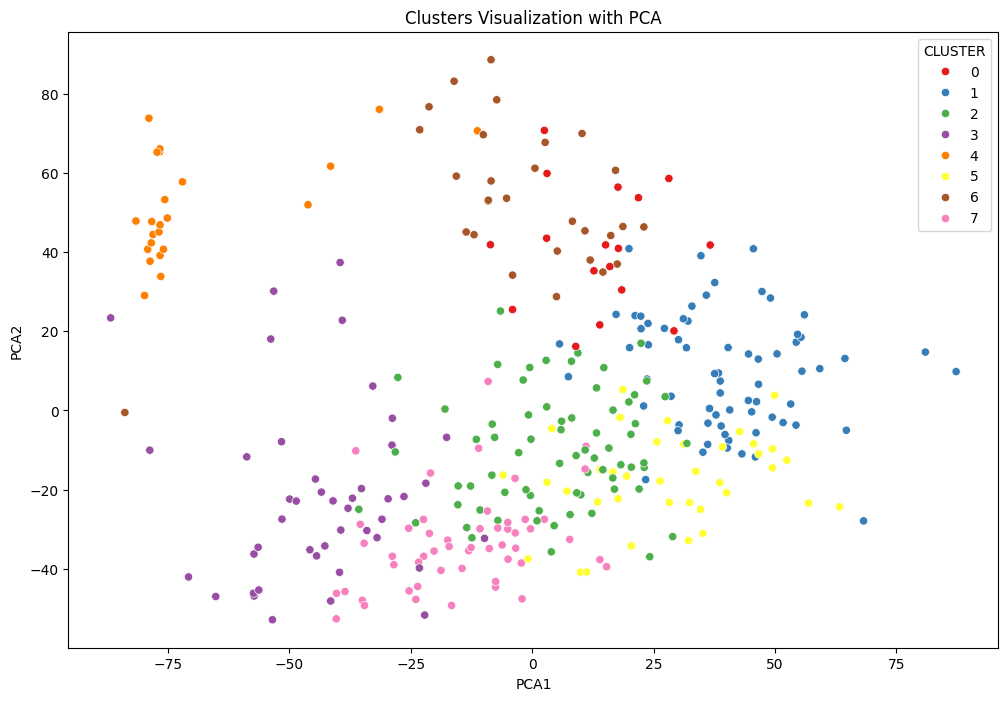

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

# Assuming result17_18 is your final DataFrame with clustering results
# Perform PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(result18_19.drop(['PLAYER', 'TEAM', 'CLUSTER'], axis=1))

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
pca_df['CLUSTER'] = result18_19['CLUSTER']

# Plot the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='CLUSTER', palette='Set1', data=pca_df, legend='full')
plt.title('Clusters Visualization with PCA')
plt.show()

In [ ]:
# clusters.loc[:,['PLAYER', 'SILHOUETTE COEFFICIENT'] + col_names].sort_values(by=['SILHOUETTE COEFFICIENT'],ascending=False)

In [ ]:
for i in range(8):
  print(f"CLUSTER {i}")
  print(result18_19.loc[result18_19['CLUSTER'] == i, 'PLAYER'])
  print()

CLUSTER 0
6                     Alex Len
15                 Aron Baynes
45                 Cody Zeller
75              Derrick Favors
94               Dwight Powell
119           Hassan Whiteside
146              Jarrett Allen
162               John Collins
188             Kenneth Faried
196               Kevon Looney
237     Michael Kidd-Gilchrist
244                   Mo Bamba
276    Rondae Hollis-Jefferson
298                 Taj Gibson
304              Thomas Bryant
320               Tyler Zeller
329         Wendell Carter Jr.
Name: PLAYER, dtype: object

CLUSTER 1
2       Al-Farouq Aminu
10       Andre Iguodala
14     Anthony Tolliver
29          Brook Lopez
31        Bruno Caboclo
             ...       
312        Torrey Craig
314      Treveon Graham
317          Trey Lyles
325        Vince Carter
334     Wilson Chandler
Name: PLAYER, Length: 68, dtype: object

CLUSTER 2
0        Aaron Gordon
3          Alec Burks
8       Allonzo Trier
11     Andrew Wiggins
16      Austin Rivers

In [ ]:
cols = [f'CLUSTER {i} DISTANCE' for i in range(8)]
cols = ['PLAYER', 'CLUSTER', 'SILHOUETTE COEFFICIENT'] + cols
result18_19.loc[:, cols]

,PLAYER,CLUSTER,SILHOUETTE COEFFICIENT,CLUSTER 0 DISTANCE,CLUSTER 1 DISTANCE,CLUSTER 2 DISTANCE,CLUSTER 3 DISTANCE,CLUSTER 4 DISTANCE,CLUSTER 5 DISTANCE,CLUSTER 6 DISTANCE,CLUSTER 7 DISTANCE
0,Aaron Gordon,2,0.014880,3.265769,5.111733,2.504274,3.803850,7.265770,5.904709,4.890954,3.658130
1,Al Horford,3,0.301873,6.291893,5.590068,5.541167,2.732572,7.548201,8.202796,6.968991,5.421791
2,Al-Farouq Aminu,7,0.300008,4.365347,6.126000,5.128297,5.301972,8.700959,7.241339,4.818260,1.937464
3,Alan Williams,4,0.299468,11.113824,6.109186,9.669434,7.608717,3.350551,11.860993,11.902824,9.986391
4,Alec Burks,2,-0.065526,2.867617,6.901382,2.572983,5.798706,8.908344,4.803276,5.192042,4.796224
...,...,...,...,...,...,...,...,...,...,...,...
325,Wilson Chandler,2,0.031028,3.167746,5.876798,2.326750,3.974423,7.902500,5.591371,5.037062,3.966193
326,Yogi Ferrell,5,0.353276,5.257554,9.981207,5.745473,8.671320,11.431688,2.370855,7.948207,8.081787
327,Zach LaVine,0,0.204366,3.562886,8.815746,4.645512,7.425516,10.468189,5.640064,5.153348,6.560295
328,Zach Randolph,3,0.271617,7.913206,4.883514,5.738815,3.054009,5.867054,9.051016,9.064722,7.187671


# 2015-2016 Season Clusters

In [ ]:
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.width', None)  # Display full width

for i in range(8):
  print(f"CLUSTER {i}")
  print(result18_19.loc[result18_19['CLUSTER'] == i, 'PLAYER'])
  print()

CLUSTER 0
20                Arron Afflalo
22                Avery Bradley
29                 Bradley Beal
36                  Buddy Hield
37                  C.J. Watson
40                 Caris LeVert
42             Chandler Parsons
49                 Courtney Lee
54             Danilo Gallinari
57                   Dante Exum
76                 Devin Harris
87                E'Twaun Moore
93                  Eric Gordon
95                Evan Fournier
98               Garrett Temple
99                  Gary Harris
103            Gerald Henderson
114               Iman Shumpert
115               Isaiah Canaan
128                Jamal Murray
142                Jerian Grant
148                  Joe Ingles
158             Jordan Crawford
159               Jordan Farmar
162             Josh Richardson
176               Kent Bazemore
177    Kentavious Caldwell-Pope
192           Langston Galloway
202               Manu Ginobili
207                Marcus Smart
208             Marcus Thornto